In [1]:
import torch
import os
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [4]:
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = TextDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [5]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [6]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            preds = outputs.logits.argmax(dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), all_preds, all_labels

In [7]:
def train_model(train_data_loader, val_data_loader, model, optimizer, device, epochs, tokenizer, path, start_epoch=0):
    history, last_epoch = load_training_history(os.path.join(path, 'training_log.csv'))

    if start_epoch == 0:
        start_epoch = last_epoch + 1

    for epoch in range(start_epoch, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device)
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss, _, _ = eval_model(model, val_data_loader, device)
        print(f'Validation loss {val_loss} accuracy {val_acc}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save model and tokenizer
        save_model(model, tokenizer, path, epoch)

        # Log metrics to CSV
        log_metrics_to_csv(path, epoch, train_acc, train_loss, val_acc, val_loss)

    return history

In [8]:
def save_model(model, tokenizer, path, epoch):
    model_save_path = os.path.join(path, f'model_epoch_{epoch}')
    tokenizer_save_path = os.path.join(path, 'tokenizer')

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    if not os.path.exists(tokenizer_save_path):
        os.makedirs(tokenizer_save_path)

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(tokenizer_save_path)
    print(f'Model and tokenizer saved at epoch {epoch}')

In [9]:
def log_metrics_to_csv(path, epoch, train_acc, train_loss, val_acc, val_loss):
    csv_path = os.path.join(path, 'training_log.csv')

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss'])
        writer.writerow([epoch, train_acc, train_loss, val_acc, val_loss])
    print(f'Metrics logged at epoch {epoch}')

In [10]:
def preprocess(texts, tokenizer, max_len):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encodings

In [11]:
def predict(texts, model, tokenizer, max_len, device):
    model = model.eval()
    encodings = preprocess(texts, tokenizer, max_len)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
    logits = outputs.logits
    preds = logits.argmax(dim=1).cpu().numpy()
    softmax_probs = torch.softmax(logits, dim=1).cpu().numpy()

    return preds, softmax_probs

In [12]:
def plot_history(history):
    train_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in history['train_acc']]
    val_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in history['val_acc']]
    train_loss = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in history['train_loss']]
    val_loss = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in history['val_loss']]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def load_training_history(csv_path):
    if not os.path.isfile(csv_path):
        return {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}, 0

    df = pd.read_csv(csv_path)
    history = {
        'train_acc': df['Train Accuracy'].tolist(),
        'train_loss': df['Train Loss'].tolist(),
        'val_acc': df['Validation Accuracy'].tolist(),
        'val_loss': df['Validation Loss'].tolist()
    }
    last_epoch = df['Epoch'].max()
    return history, last_epoch

In [14]:
def load_model_and_tokenizer(model_path, tokenizer_path):
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, tokenizer, device

In [15]:
EPOCHS = 20
MAX_LEN = 30
BATCH_SIZE = 512
LEARNING_RATE = 2e-5

MODEL_NAME = 'bert-base-multilingual-uncased'

dir = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Dataset Statistics/dataset'
# dir = '../Dataset Statistics/dataset'

path = f'/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/saved_models/{(MODEL_NAME[:MODEL_NAME.find("-")])}_{EPOCHS}__epochs'
# path = f'Model training/saved_models/{(MODEL_NAME[:MODEL_NAME.find('-')])}_{EPOCHS}__epochs'

In [16]:
train_df = pd.read_csv(f'{dir}/train.csv')
val_df = pd.read_csv(f'{dir}/val.csv')
test_df = pd.read_csv(f'{dir}/test.csv')

train_texts_english = train_df['english_text'].values
val_texts_english = val_df['english_text'].values
test_texts_english = test_df['english_text'].values

train_texts_urdu = train_df['urdu_text'].values
val_texts_urdu = val_df['urdu_text'].values
test_texts_urdu = test_df['urdu_text'].values

train_texts = np.concatenate([train_texts_english, train_texts_urdu])
val_texts = np.concatenate([val_texts_english, val_texts_urdu])
test_texts = np.concatenate([test_texts_english, test_texts_urdu])

train_labels = train_df['class'].values
val_labels = val_df['class'].values
test_labels = test_df['class'].values

train_labels = np.concatenate([train_labels, train_labels])
val_labels = np.concatenate([val_labels, val_labels])
test_labels = np.concatenate([test_labels, test_labels])

In [ ]:
model, tokenizer, device = load_model_and_tokenizer(MODEL_NAME, MODEL_NAME)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_texts, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = train_model(train_data_loader, val_data_loader, model, optimizer, device, EPOCHS, tokenizer, path)

Epoch 1/20
----------
Train loss 0.17186733750210786 accuracy 0.9183818031561134
Validation loss 0.14159594738157466 accuracy 0.9381727664155006
Model and tokenizer saved at epoch 1
Metrics logged at epoch 1
Epoch 2/20
----------
Train loss 0.12832817422568285 accuracy 0.9409671664502249
Validation loss 0.13710452170184284 accuracy 0.9383938182377365
Model and tokenizer saved at epoch 2
Metrics logged at epoch 2
Epoch 3/20
----------
Train loss 0.11445708812883236 accuracy 0.9476375060669263
Validation loss 0.12930983175451105 accuracy 0.9422478087036753
Model and tokenizer saved at epoch 3
Metrics logged at epoch 3
Epoch 4/20
----------
Train loss 0.10084802045306385 accuracy 0.9545931551952566
Validation loss 0.14337039517205066 accuracy 0.9412867138243888
Model and tokenizer saved at epoch 4
Metrics logged at epoch 4
Epoch 5/20
----------


In [ ]:
plot_history(history)

In [ ]:
model, tokenizer, device = load_model_and_tokenizer(f'{path}/model_epoch_4', f'{path}/tokenizer')
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_acc, test_loss, test_label_actual, test_label_pred = eval_model(model, test_data_loader, device)
print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 0.13651231076526252 accuracy 0.9433792420559908


In [ ]:
cm = confusion_matrix(test_label_actual, test_label_pred)
report = classification_report(test_label_actual, test_label_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     91256
           1       0.83      0.86      0.84     19834

    accuracy                           0.94    111090
   macro avg       0.90      0.91      0.90    111090
weighted avg       0.94      0.94      0.94    111090



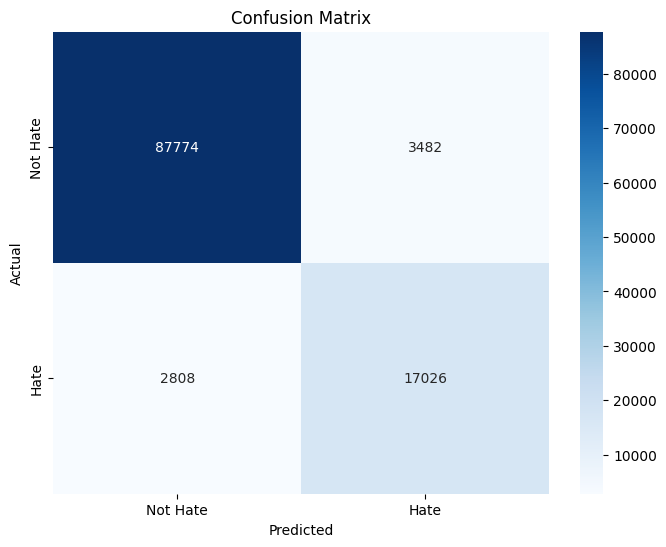

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_texts = ["This is the sort of thing that happens in a shithole country. @URL"]
preds, confidence = predict(test_texts, model, tokenizer, MAX_LEN, device)

if preds[0] == 1:
    print(f'Predicted class: Hate Speech \nConfidence: {confidence[0][1]:.2f}')
else:
    print(f'Predicted class: Not Hate Speech \nConfidence: {confidence[0][0]:.2f}')

Predicted class: Hate Speech 
Confidence: 0.89


In [ ]:
test_texts = ["هي اهڙي قسم جي شيءِ آهي جيڪا هڪ شيٿول ملڪ ۾ ٿئي ٿي. @URL"]
preds, confidence = predict(test_texts, model, tokenizer, MAX_LEN, device)

if preds[0] == 1:
    print(f'Predicted class: Hate Speech \nConfidence: {confidence[0][1]:.2f}')
else:
    print(f'Predicted class: Not Hate Speech \nConfidence: {confidence[0][0]:.2f}')

Predicted class: Not Hate Speech 
Confidence: 0.53


In [ ]:
import torch.optim as optim

path = 'Model training/saved_models/mBert_10_epochs'

model_path = os.path.join(path, 'model_epoch_last')
tokenizer_path = os.path.join(path, 'tokenizer')
model, tokenizer, device = load_model_and_tokenizer(model_path, tokenizer_path)

optimizer = optim.Adam(model.parameters(), lr=2e-5)

history = train_model(train_data_loader, val_data_loader, model, optimizer, device, EPOCHS, tokenizer, path)